In [1]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split,cross_validate, KFold, StratifiedKFold, GridSearchCV # 학습, 테스트set 구분
import sklearn.metrics as mt # 성능지표를 계산하기 위해 import
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate # 교차검증

import warnings
warnings.filterwarnings('ignore')

In [2]:
df  = pd.read_csv('/content/drive/MyDrive/Dacon/train.csv')
test  = pd.read_csv('/content/drive/MyDrive/Dacon/test.csv')

# Train 데이터 전처리

In [3]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# Feature drop 
# 'index', 'country'
processed_data = df.drop(['index', 'country'], axis=1).copy()

In [4]:
# Handling missing values with simple imputator
# 'education', 'gender', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer

fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
transformer = SimpleImputer()
processed_data[fill_cols] = transformer.fit_transform(processed_data[fill_cols])
processed_data[fill_cols].describe()

,education,gender,engnat,hand,religion,orientation,voted,married,ASD
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2.314232,1.703024,1.346018,1.185113,4.098340,1.847956,1.633121,1.179917,1.938703
std,0.916050,0.552935,0.474969,0.481237,3.397606,1.206812,0.480602,0.464709,0.239170
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000
50%,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000
75%,3.000000,2.000000,2.000000,1.000000,6.000000,2.000000,2.000000,1.000000,2.000000
max,4.000000,3.000000,2.000000,3.000000,12.000000,5.000000,2.000000,3.000000,2.000000


count    15000.000000
mean         2.298851
std          0.836876
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: familysize, dtype: float64


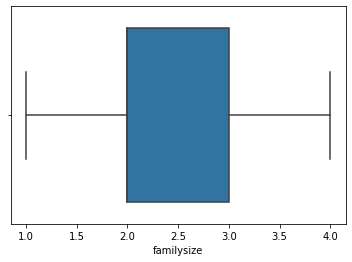

In [5]:
# Handling outlier
# 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
processed_data[['familysize', 'nerdiness']] = transformer.fit_transform(processed_data[['familysize', 'nerdiness']])
print(processed_data['familysize'].describe())
sns.boxplot(x='familysize', data=processed_data)

0        3.05
1        3.10
2        3.00
3        2.95
4        2.95
         ... 
14995    3.15
14996    2.80
14997    3.00
14998    2.65
14999    2.95
Name: Mach, Length: 15000, dtype: float64

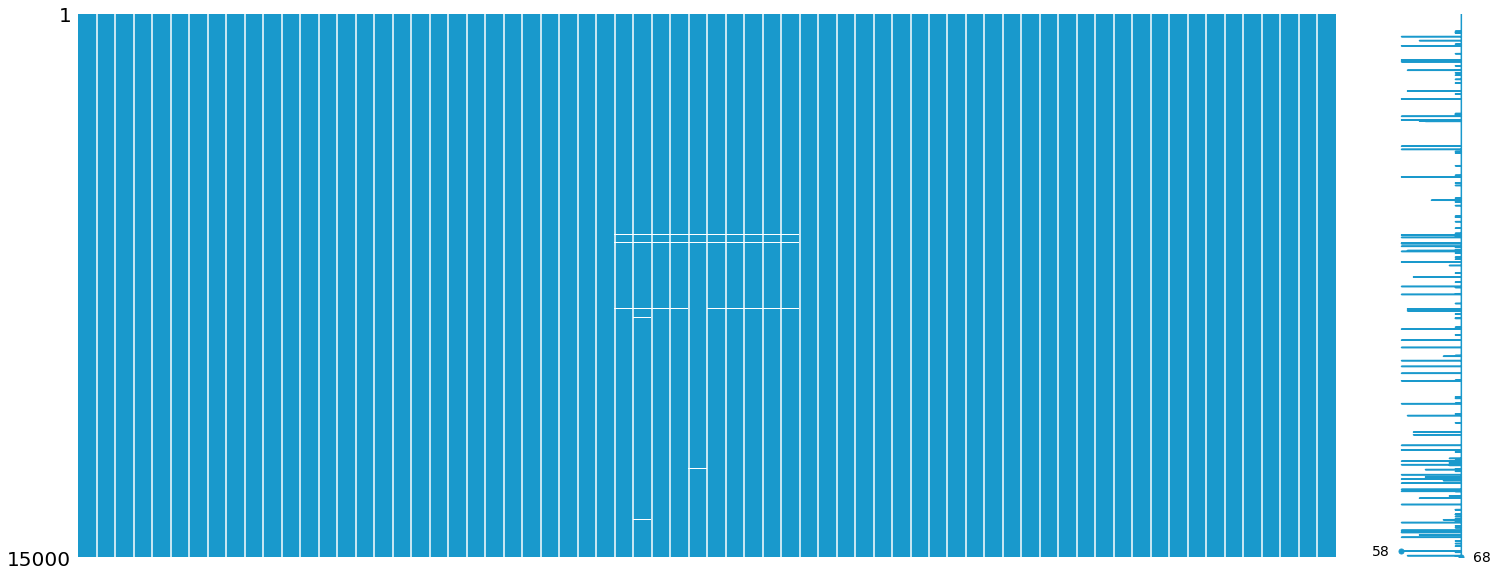

In [6]:
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]

for col in [npas_cols] : 
    transformer = SimpleImputer()
    processed_data[col] = transformer.fit_transform(processed_data[col])
    
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

processed_data = score_mach(processed_data)
processed_data['Mach']

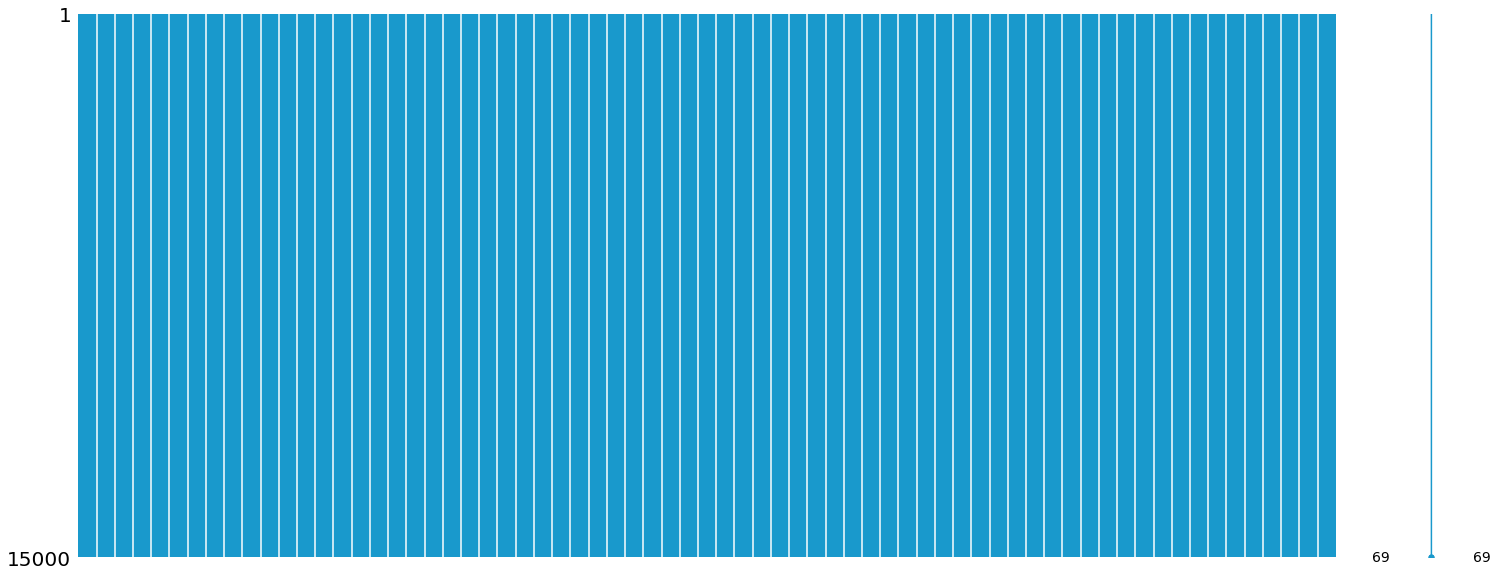

In [7]:
processed_data = processed_data.fillna(0) #test 결측치 0으로 채우기
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

In [8]:
train = processed_data.copy()

# test data 전처리

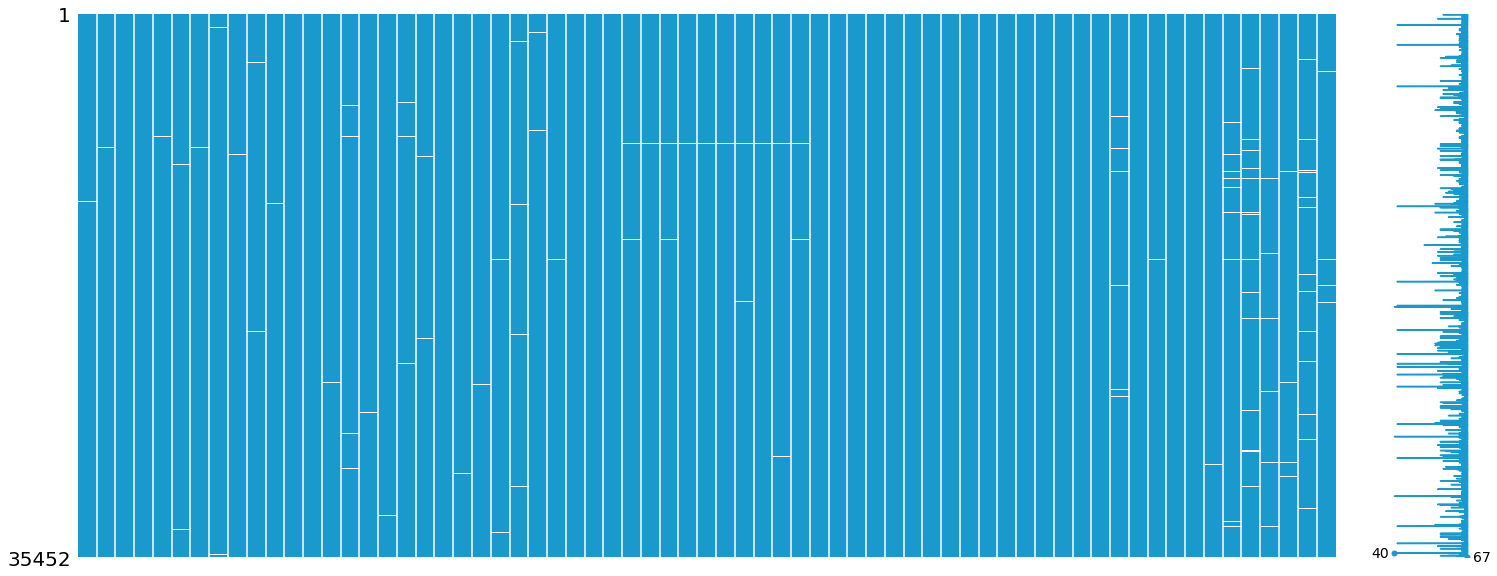

In [9]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 

# Feature drop : 'index'
test = test.drop(['index', 'country'], axis=1).copy()
msno.matrix(test.iloc[:, :], color=(0.1, 0.6, 0.8))

# Handling missing values : 'education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer
fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
transformer = SimpleImputer()
test[fill_cols] = transformer.fit_transform(test[fill_cols])
test[fill_cols].describe()

# Handling outlier and iterative imputation : 'familysize'
Q1 = test['familysize'].quantile(0.25)
Q2 = test['familysize'].quantile(0.5)
Q3 = test['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
test['familysize'] = test['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
test[['familysize']] = transformer.fit_transform(test[['familysize']])
test['familysize'] = test['familysize'].astype(int)

In [10]:
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]

for col in [npas_cols] : 
    transformer = SimpleImputer()
    test[col] = transformer.fit_transform(test[col])
    
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

test = score_mach(test)

In [11]:
test = test.fillna(0)

# Data split

In [12]:
# train = df.drop(['index', 'country'],axis = 1)
# test =test.drop(['index', 'country'],axis = 1)
# train = train.fillna(0) #test 결측치 0으로 채우기
# test = test.fillna(0)

In [13]:
#train을 target과 feature로 나눠줍니다.
train_x=train.drop(['nerdiness'], axis=1)
train_y=train['nerdiness']

In [14]:
# 학습, 테스트 데이터 분리 (0.7:0.3)
seed = 2022
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=seed, stratify = train_y)

# Build Model

In [15]:
xtree = ExtraTreesClassifier(n_estimators=5000, random_state=2022)

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(train_x, train_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_valid, x_test_fold = train_x.iloc[train_index], train_x.iloc[test_index]
    y_valid, y_test_fold = train_y[train_index], train_y[test_index]
    
    xtree.fit(x_valid, y_valid)
    pred = xtree.predict(x_test_fold)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test_fold, pred), 4) # 소수점 4자리 반올림
    train_size = x_valid.shape[0]
    test_size = x_test_fold.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    pred_proba = xtree.predict_proba(x_test_fold)[:,1]
    print("AUC score : ", roc_auc_score(y_test_fold, pred_proba))
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))



#1 교차 검증 정확도 : 0.7837,  학습 데이터 크기 : 12000,  검증 데이터 크기 : 3000
#1 검증 세트 인덱스 : [   0    1    2 ... 3027 3030 3031]
AUC score :  0.8794485267834461

#2 교차 검증 정확도 : 0.796,  학습 데이터 크기 : 12000,  검증 데이터 크기 : 3000
#2 검증 세트 인덱스 : [2962 2966 2968 ... 6026 6028 6029]
AUC score :  0.8872629974025203

#3 교차 검증 정확도 : 0.774,  학습 데이터 크기 : 12000,  검증 데이터 크기 : 3000
#3 검증 세트 인덱스 : [5966 5967 5969 ... 9034 9035 9040]
AUC score :  0.8716144975066084

#4 교차 검증 정확도 : 0.7987,  학습 데이터 크기 : 12000,  검증 데이터 크기 : 3000
#4 검증 세트 인덱스 : [ 8976  8977  8978 ... 12037 12038 12041]
AUC score :  0.8914693850026973

#5 교차 검증 정확도 : 0.7823,  학습 데이터 크기 : 12000,  검증 데이터 크기 : 3000
#5 검증 세트 인덱스 : [11961 11962 11964 ... 14997 14998 14999]
AUC score :  0.8796275400107894

## 평균 검증 정확도: 0.7869400000000001


In [17]:
pred = xtree.predict_proba(x_test)[:,1]
print(roc_auc_score(y_test, pred))

0.9953410176086374


기록

1. xtree = ExtraTreesClassifier(n_estimators=3000, random_state=2022)
- 전처리 그냥 fillna(0)
- 0.9954036622433095

2. xtree = ExtraTreesClassifier(n_estimators=3000, random_state=2022)
- 형빈 전처리 다함
- 0.9953244322667626

# AUC 테스트

In [18]:
model = ExtraTreesClassifier(n_estimators=5000, random_state=2022)

In [19]:
rows = len(train.index)
columns = len(train.columns)

Train = train[:int(rows*0.8)]
Valid = train[int(rows*0.8):]
Valid

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness,Mach
12000,2.0,4.0,2.0,5.0,2.0,4.0,1.816738,4.0,2.0,5.0,...,29,1.0,2.0,1.0,1.0,1.0,2.0,2.0,0.0,2.840837
12001,3.0,5.0,2.0,2.0,4.0,3.0,2.000000,5.0,3.0,1.0,...,18,1.0,7.0,1.0,2.0,1.0,3.0,2.0,1.0,3.050000
12002,5.0,3.0,1.0,1.0,5.0,4.0,1.000000,5.0,1.0,1.0,...,16,1.0,2.0,1.0,2.0,1.0,2.0,2.0,0.0,2.600000
12003,2.0,4.0,2.0,2.0,4.0,2.0,1.000000,2.0,3.0,2.0,...,36,1.0,6.0,1.0,1.0,3.0,3.0,2.0,0.0,2.600000
12004,3.0,5.0,2.0,3.0,5.0,4.0,2.000000,4.0,1.0,1.0,...,46,1.0,4.0,3.0,1.0,1.0,2.0,2.0,0.0,2.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.0,5.0,2.0,3.0,3.0,4.0,2.000000,4.0,3.0,2.0,...,17,1.0,1.0,3.0,2.0,1.0,3.0,2.0,0.0,3.150000
14996,5.0,4.0,1.0,2.0,4.0,5.0,1.000000,4.0,2.0,1.0,...,45,1.0,3.0,1.0,1.0,2.0,3.0,2.0,1.0,2.800000
14997,4.0,5.0,1.0,1.0,5.0,5.0,1.000000,5.0,2.0,1.0,...,20,1.0,1.0,2.0,1.0,1.0,3.0,1.0,1.0,3.000000
14998,5.0,5.0,2.0,1.0,5.0,5.0,1.000000,1.0,1.0,1.0,...,29,1.0,12.0,4.0,2.0,2.0,2.0,1.0,0.0,2.650000


In [20]:
X_train = Train.drop(['nerdiness'], axis=1)
Y_train = Train['nerdiness']
X_test = Valid.drop(['nerdiness'], axis=1)
Y_test = Valid['nerdiness']

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

def stratifiedkfold(train_x, train_y, n_splits=5):
  kfold = StratifiedKFold(n_splits)
  cv_accuracy = []
  n_iter =0

  for train_index, test_index in kfold.split(train_x, train_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
      x_valid, x_test_fold = train_x.iloc[train_index], train_x.iloc[test_index]
      y_valid, y_test_fold = train_y[train_index], train_y[test_index]
      
      model.fit(x_valid, y_valid)
      pred = model.predict(x_test_fold)
      n_iter += 1
      
      accuracy = np.round(accuracy_score(y_test_fold, pred), 4) # 소수점 4자리 반올림
      train_size = x_valid.shape[0]
      test_size = x_test_fold.shape[0]
      
      print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
            .format(n_iter, accuracy, train_size, test_size))
      print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
      cv_accuracy.append(accuracy)
      
  print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

In [22]:
stratifiedkfold(X_train, Y_train)


#1 교차 검증 정확도 : 0.7704,  학습 데이터 크기 : 9600,  검증 데이터 크기 : 2400
#1 검증 세트 인덱스 : [   0    1    2 ... 2461 2462 2463]

#2 교차 검증 정확도 : 0.7871,  학습 데이터 크기 : 9600,  검증 데이터 크기 : 2400
#2 검증 세트 인덱스 : [2315 2320 2324 ... 4843 4845 4847]

#3 교차 검증 정확도 : 0.7688,  학습 데이터 크기 : 9600,  검증 데이터 크기 : 2400
#3 검증 세트 인덱스 : [4759 4762 4766 ... 7265 7267 7268]

#4 교차 검증 정확도 : 0.7858,  학습 데이터 크기 : 9600,  검증 데이터 크기 : 2400
#4 검증 세트 인덱스 : [7083 7086 7087 ... 9631 9634 9635]

#5 교차 검증 정확도 : 0.7808,  학습 데이터 크기 : 9600,  검증 데이터 크기 : 2400
#5 검증 세트 인덱스 : [ 9553  9554  9556 ... 11997 11998 11999]

## 평균 검증 정확도: 0.77858


In [23]:
Pred = model.predict_proba(X_test)[:,1]
# 학습결과 평가
print("Train_Accuracy : ", model.score(X_train, Y_train))
print("Test_Accuracy : ", model.score(X_test, Y_test), '\n')

print(roc_auc_score(Y_test, Pred))

Train_Accuracy :  0.9561666666666667
Test_Accuracy :  0.7726666666666666 

0.8651264347202294


# 기록

1. model = ExtraTreesClassifier(n_estimators=3000, random_state=2022)
- fillna(0)
- 0.8645942431850788

2. model = ExtraTreesClassifier(n_estimators=3000, random_state=2022)
- 형빈이 전처리
- 0.8650329537302726

# Submission

In [24]:
# 학습한 모델로 예측수행
pred_submission = xtree.predict_proba(test)[:,1]

In [25]:
submission = pd.read_csv('/content/drive/MyDrive/Dacon/sample_submission.csv')

submission

,index,nerdiness
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1
...,...,...
35447,35447,-1
35448,35448,-1
35449,35449,-1
35450,35450,-1


In [26]:
submission["nerdiness"] = pred_submission

In [27]:
submission

,index,nerdiness
0,0,0.0000
1,1,0.8082
2,2,0.8334
3,3,0.5984
4,4,0.6026
...,...,...
35447,35447,1.0000
35448,35448,0.7172
35449,35449,0.9132
35450,35450,0.0102


In [28]:
submission.to_csv("/content/drive/MyDrive/Dacon/ExtraTree.csv", index = False)